# Predicting machine failure

Predicting machine failure through machine learning is paramount for efficient industrial operations. By analysing data patterns, ML models can forecast potential breakdowns, allowing for proactive maintenance and minimising downtime. This predictive approach not only enhances equipment reliability but also optimises resource allocation.

## Scope

**_Context_**

* [The AI4I 2020 Predictive Maintenance Dataset](https://archive.ics.uci.edu/dataset/601/ai4i+2020+predictive+maintenance+dataset) is a synthetic dataset that reflects real predictive maintenance data encountered in industry.

* It will be assumed that faulty machinery would lead to decreased productivity and efficiency, quality issues, defective products, and potentially safety concerns for workers.

**_Model_**

* The machine failure consists of five independent failure modes. However, initially this problem will be framed as a binary classification problem.

* No baseline model is available for benchmarking. The model will therefore be compared to a no-skill classifier.

**_Technical requirements_**

* In reality, the model would likely be deployed to an online endpoint so predictions could be generated in real time (via a REST API).

* At this stage, the model will not be deployed. However, the low latency requirements of online deployment does place constraints on infrastructure and model complexity. For this reason, neural networks will not be tested as they can be slow at inference time due to the large number of operations.

**_Data requirements_**

* No further data collection is required.

* No personal data is involved. Consequently there are no clear legal/ethical constraints (e.g. GDPR).

## Model performance metrics

* The performance metrics should align closely with the specific business problem at hand.

* While a single metric simplifies ranking model performance, the dataset's imbalance makes overall accuracy unsuitable.

* It is assumed the cost of a false negative prediction (incorrectly identifying something as okay when it has failed) outweighs the cost of a false positive prediction.

* The primary metric is therefore recall for the minority (failure) class, reflecting the model's ability to identify failed machinery and aiming to minimise false negatives.

    $Recall = \frac{TP}{TP + FN}$

* A secondary metric is precision for the minority (failure) class, minimising false positives and ensuring high accuracy in failed predictions. The optimisation target is a nominal constraint of 50% precision.

    $Precision = \frac{TP}{TP + FP}$

* Striking a balance involves achieving a reasonable level of precision to prevent unnecessary disruptions while maintaining a sufficiently high recall for effective fault detection.

    Note: AUC on the Precision-Recall will also allow for the comparison of different models in terms of their ability to balance precision and recall.

## Import dependencies

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns

import sys
sys.path.insert(0, "C:\\Users\\billy\\OneDrive\\Documents\\Python Scripts\\1. Portfolio\\machine-failure\\machine-failure")
import custom_funcs as cf

from sklearn.model_selection import KFold
from mixed_naive_bayes import MixedNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

## Import raw data

The dataset consists of 10,000 data points stored as rows with 14 features in columns.

* **UID:** Unique identifier ranging from 1 to 10000

* **productID:** Consisting of a letter L, M, or H for low (50% of all products), medium (30%), and high (20%) as product quality variants and a variant-specific serial number

* **air temperature [K]:** Generated using a random walk process later normalized to a standard deviation of 2 K around 300 K

* **process temperature [K]:** Generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.

* **rotational speed [rpm]:** Calculated from powepower of 2860 W, overlaid with a normally distributed noise

* **torque [Nm]:** Torque values are normally distributed around 40 Nm with an Ïƒ = 10 Nm and no negative values.

* **tool wear [min]:** The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process. and a 'machine failure' label that indicates, whether the machine has failed in this particular data point for any of the following failure modes are true.

* **Target:** Failure or Not

* **Failure Type:** Type of Failure

In [2]:
raw_df = pd.read_csv(cf.file_directory("raw") + "predictive_maintenance.csv")
raw_df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


## Import cleaned data

* Please note data exploration and cleaning is performed in the accompanying 'data_exploration.ipynb' workbook.

In [3]:
train_df = pd.read_csv(cf.file_directory('cleaned') + 'train_df.csv')
test_df = pd.read_csv(cf.file_directory('cleaned') + 'test_df.csv')
train_df.head()

,Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Type_H,Type_L,Type_M,Target,Failure Type_Heat,Failure Type_None,Failure Type_Overstrain,Failure Type_Power,Failure Type_Random,Failure Type_Tool
0,310.7,1454,39.4,17,0,0,1,0,0,1,0,0,0,0
1,309.7,1868,23.8,118,0,0,1,0,0,1,0,0,0,0
2,308.5,1616,30.2,34,0,1,0,0,0,1,0,0,0,0
3,312.6,1768,23.9,149,0,0,1,0,0,1,0,0,0,0
4,313.4,1624,32.1,53,0,0,1,0,0,1,0,0,0,0


In [4]:
scaled_train_df = pd.read_csv(cf.file_directory('cleaned') + 'scaled_train_df.csv')
scaled_test_df = pd.read_csv(cf.file_directory('cleaned') + 'scaled_test_df.csv')
scaled_train_df.head()

,Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Type_H,Type_L,Type_M,Target,Failure Type_Heat,Failure Type_None,Failure Type_Overstrain,Failure Type_Power,Failure Type_Random,Failure Type_Tool
0,0.617284,0.160117,0.489011,0.067194,0,0,1,0,0,1,0,0,0,0
1,0.493827,0.402933,0.274725,0.466403,0,0,1,0,0,1,0,0,0,0
2,0.345679,0.255132,0.362637,0.134387,0,1,0,0,0,1,0,0,0,0
3,0.851852,0.344282,0.276099,0.588933,0,0,1,0,0,1,0,0,0,0
4,0.950617,0.259824,0.388736,0.209486,0,0,1,0,0,1,0,0,0,0


In [5]:
qt_train_df = pd.read_csv(cf.file_directory('cleaned') + 'qt_train_df.csv')
qt_test_df = pd.read_csv(cf.file_directory('cleaned') + 'qt_test_df.csv')
qt_train_df.head()

,Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Type_H,Type_L,Type_M,Target,Failure Type_Heat,Failure Type_None,Failure Type_Overstrain,Failure Type_Power,Failure Type_Random,Failure Type_Tool
0,0.412900,-0.392492,-0.062770,-1.334066,0,0,1,0,0,1,0,0,0,0
1,-0.175278,1.669112,-1.625274,0.146048,0,0,1,0,0,1,0,0,0,0
2,-0.926176,0.691121,-0.979511,-0.943656,0,1,0,0,0,1,0,0,0,0
3,1.684464,1.374878,-1.615945,0.510631,0,0,1,0,0,1,0,0,0,0
4,2.511791,0.733156,-0.771450,-0.645631,0,0,1,0,0,1,0,0,0,0


## Train/test prep

* The train/test split is performed.

In [6]:
cols = ['Process temperature [K]','Rotational speed [rpm]','Torque [Nm]','Tool wear [min]', 'Type_H', 'Type_L', 'Type_M']
X_train = train_df[cols]
X_test = test_df[cols]

y_train = train_df['Target']
y_test = test_df['Target']

In [7]:
# Scaled data
cols = ['Process temperature [K]','Rotational speed [rpm]','Torque [Nm]','Tool wear [min]', 'Type_H', 'Type_L', 'Type_M']
X_train_scaled = scaled_train_df[cols]
X_test_scaled = scaled_test_df[cols]

y_train_scaled = scaled_train_df['Target']
y_test_scaled = scaled_test_df['Target']

In [8]:
# Transformed data
cols = ['Process temperature [K]','Rotational speed [rpm]','Torque [Nm]','Tool wear [min]', 'Type_H', 'Type_L', 'Type_M']
X_train_qt = qt_train_df[cols]
X_test_qt = qt_test_df[cols]

y_train_qt = qt_train_df['Target']
y_test_qt = qt_test_df['Target']

## Model selection
* It's a binary classification problem.

* The following models will be tested:
    - Naive Bayes (generative probabilistic model)
    - Logistic regression (discriminative probabilistic model & linear classifier)
    - Support Vector Machine (non-linear classifier)

## Model training

### Custom functions
* Where possible, precision-recall curves will be used to select optimal probability thresholds.

* The optimal probability threshold is that which maximises recall given a minimum precision.

In [48]:
def find_optimal_threshold(precision, recall, thresholds, min_precision=0.5):
    """
    Finds the probability threshold that maximises recall whilst ensuring precision is above or equal to a minimum value.
    """

    # The last precision and recall values are 1. and 0. respectively and do not have a corresponding threshold.
    precision = precision[:-1]
    recall = recall[:-1]
    
    # Ensure input lists have the same length
    assert len(precision) == len(recall) == len(thresholds), "Arrays must have the same length"

    # Filter thresholds based on the minimum precision requirement
    eligible_thresholds = [t for t, p in zip(thresholds, precision) if p >= min_precision]

    # If no eligible thresholds are found, return None
    if not eligible_thresholds:
        return None

    # Find the threshold that maximizes recall among the eligible thresholds
    optimal_threshold = max(eligible_thresholds, key=lambda t: recall[eligible_thresholds.index(t)])
    optimal_precision = precision[thresholds.tolist().index(optimal_threshold)]
    optimal_recall = recall[thresholds.tolist().index(optimal_threshold)]

    return optimal_threshold, optimal_precision, optimal_recall

### Naive Bayes
* Gaussian Naive Bayes is conducted. This means likelihood is modelled with a Gaussian.

* It is considered a generative probabilistic classifier because it models the joint probability distribution of the input features and the class labels.

**Background**

* Naive Bayes is a conditional probability model:

    $P(C_k|\boldsymbol{X}) = \frac{P(\boldsymbol{X}|C_k)P(C_k)}{P(\boldsymbol{X})}$

* Using Bayesian probability terminology:

    $posterior = \frac{likelihood \times prior}{evidence}$

* In practice, there is interest only in the numerator of that fraction, because the denominator does not depend on class

    $P(C_k|\boldsymbol{X}) \propto P(\boldsymbol{X}|C_k)P(C_k)$

* This is equivalent to the joint probability:

    $P(C_k|\boldsymbol{X}) \propto P(\boldsymbol{X} \cap C_k)$

    $P(C_k|\boldsymbol{X}) \propto P(C_k \cap \boldsymbol{x}_1 \cap \boldsymbol{x}_2 \cap \boldsymbol{x}_3...\boldsymbol{x}_n)$

* This can be rewritten via the chain rule:

    $P(C_k|\boldsymbol{X}) \propto P(\boldsymbol{x}_1 | \boldsymbol{x}_2,...,\boldsymbol{x}_n, C_k)P(\boldsymbol{x}_2 | \boldsymbol{x}_3,...,\boldsymbol{x}_n, C_k)P(\boldsymbol{x}_{n-1} | \boldsymbol{x}_n, C_k)P(\boldsymbol{x}_{n} | C_k)$

* Assuming conditional independence:

    $ P(\boldsymbol{x}_i | \boldsymbol{x}_{i+1},...,\boldsymbol{x}_n, C_k) = P(\boldsymbol{x}_i | C_k) $

* Enables simplification:

    $P(C_k| \boldsymbol{x}_1,...,\boldsymbol{x}_n) \propto p(C_k)p(\boldsymbol{x}_1 | C_k)p(\boldsymbol{x}_2 | C_k)...p(\boldsymbol{x}_n | C_k)$

    $P(C_k| \boldsymbol{x}_1,...,\boldsymbol{x}_n) \propto p(C_k)\prod_{i=1}^n p(\boldsymbol{x}_i | C_k)$

* Therefore we need to find the class with the maximum probability according to:

    $C_k = \text{argmax}_C \; \; \; p(C_k)\prod_{i=1}^n p(\boldsymbol{x}_i | C_k)$

**Performance**

* Naive Bayes models are  relatively simple and have few hyperparameters. Indeed, there are no hyperparameters to tune for Gaussian Naive Bayes.

* K-fold cross validation is used to assess the performance of the model with a classification threshold of $0.5$.

* A stratified split is used to maintain the class balance.

**_Key observations_**

* Recall is only $0.2$. This means the ability of the model to identify all failed machinery is poor.

    $Recall = \frac{TP}{TP+FN}$

* Precision is $0.5$. This means roughly $50\%$ of of failed predictions are correct.

    $Precision = \frac{TP}{TP+FP}$

In [9]:
# Use StratifiedKFold for cross-validation to maintain class balance
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Iterate over k-folds
precision, recall, f1 = [], [], []
for train_index, test_index in cv.split(X_train_scaled, y_train_scaled):
    X_train_k, y_train_k = X_train_scaled.loc[train_index], y_train_scaled.loc[train_index]
    X_test_k, y_test_k = X_train_scaled.loc[test_index], y_train_scaled.loc[test_index]

    # Create a pipeline with a classifier (Naive Bayes) and a quantile transformer
    num_cols = ['Process temperature [K]','Rotational speed [rpm]','Torque [Nm]','Tool wear [min]']
    preprocessor = ColumnTransformer(transformers=[('transformer', QuantileTransformer(output_distribution='normal'), num_cols)], remainder='passthrough')
    pipe = Pipeline([('preprocessor', preprocessor), ('gnb', GaussianNB())])

    # Perform predictions
    pipe.fit(X_train_k[num_cols], y_train_k)
    y_pred_k = pipe.predict(X_test_k)
    
    # Calculate precision, recall & f1-score
    precision.append(precision_score(y_test_k, y_pred_k))
    recall.append(recall_score(y_test_k, y_pred_k))
    f1.append(f1_score(y_test_k, y_pred_k))

print(f"Precision: {np.mean(precision)}")
print(f"Recall: {np.mean(recall)}")
print(f"F1: {np.sqrt(np.mean(f1))}")

Precision: 0.5034761904761905
Recall: 0.2048103607770583
F1: 0.5379288183692332


**Performance as function of classification threshold**

* Performance is assesed as a function of classification threshold using a precision-recall curve.

* This illustrates the trade-off between precision and recall at different classification thresholds:

    - As the classification threshold is lowered (moving to the right on the plot), the recall increases (as the number of FNs decreases) but the precision decreases (as the number of FPs increases)

    - As the classification threshold is increased (moving to the left on the plot), the precision increases (as the number of FPs decreases) but the recall decreases (as the number of FNs increases)

* Similar to above, K-fold cross validation is coupled with a stratified split (to maintain the class balance).

**_Key observations_**

* The AUC is $0.37$. 

* The goal is to optimise recall whilst meeting a nominal constraint of $50\%$ precision.

* The precision-recall curve shows the maximum recall possible given this constraint is $0.2$.

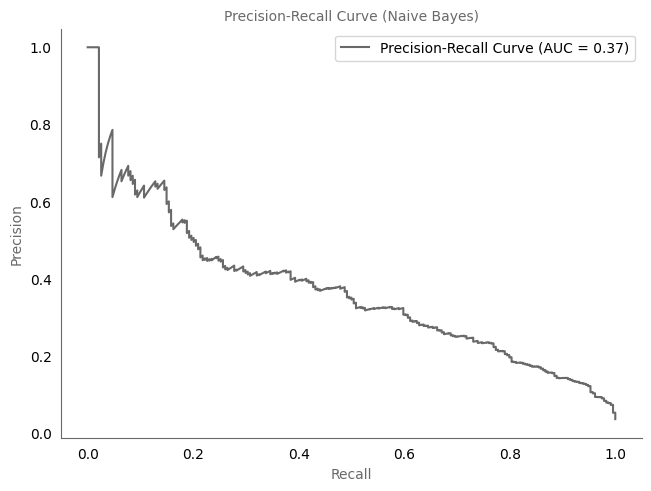

In [54]:
# Create a pipeline with a classifier (Naive Bayes) and a quantile transformer
num_cols = ['Process temperature [K]','Rotational speed [rpm]','Torque [Nm]','Tool wear [min]']
preprocessor = ColumnTransformer(transformers=[('transformer', QuantileTransformer(output_distribution='normal'), num_cols)], remainder='passthrough')
pipe = Pipeline([('preprocessor', preprocessor), ('gnb', GaussianNB())])

# Use StratifiedKFold for cross-validation to maintain class balance
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validated predictions
y_pred = cross_val_predict(pipe, X_train_scaled[num_cols], y_train_scaled, cv=cv, method='predict_proba')[:, 1]

# Calculate precision and recall
precisions, recalls, thresholds = precision_recall_curve(y_train_scaled, y_pred)

# Calculate area under the curve (AUC)
auc_score = auc(recalls, precisions)

# Plot figure
fig, axes = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(6.4, 4.8))
axes.tick_params(bottom=False, left=False)
axes.grid(False)
axes.spines[['top', 'right']].set_visible(False)
axes.spines[['left', 'bottom']].set_color('dimgray')

axes.plot(recalls, precisions, label=f'Precision-Recall Curve (AUC = {auc_score:.2f})', color='dimgray', alpha=1)
axes.set_title('Precision-Recall Curve (Naive Bayes)',fontsize=10, color='dimgray')
axes.set_xlabel('Recall',fontsize=10, color='dimgray')
axes.set_ylabel('Precision',fontsize=10, color='dimgray')
axes.legend();

In [58]:
# Compute best recall given a minimum precision
min_precision = 0.5
optimal_threshold, optimal_precision, optimal_recall = find_optimal_threshold(precisions, recalls, thresholds, min_precision)
print(f"Optimal threshold: {optimal_threshold}")
print(f"Optimal recall: {optimal_recall}")
print(f"Optimal precision: {optimal_precision}")

Optimal threshold: 0.5003551605204098
Optimal recall: 0.20512820512820512
Optimal precision: 0.5


**Conclusion**

* The goal is to maximise recall whilst ensuring precision is at least $0.5$. The maximum recall, given this constraint, was $0.2$.

* Guassian Naive Bayes therefore does not perform sufficiently well. This may be due to the assumption of conditional independence between features.
  
* Given the model only takes into account numeric features, performance may be improved using mixed naive Bayes. However, as this is not currently supported in scikit-learn, it will not be tested.

### Logistic regression

* Logistic regression is often referred to as the discriminative counterpart of Naive Bayes as it directly learns $P(Y|\boldsymbol{X})$

* As a linear model it won't work well when the decision boundary is not linear

* It's relative simplicity makes it a high-bias and low-variance model

* When features are highly correlated, the coefficients won't be as accurate (this can be addressed via regularisation, removal of features...)

**Background**

Sigmoid function:

* The sigmoid function, also known as the logistic function, is defined as follows:

    $\forall z \in R$, $\sigma(z) \in [0,1]$

    $\sigma(z)=\frac{1}{1+exp-z}$

* It outputs numbers between $0$ and $1$. At input $0$, it outputs $0.5$.

    <img src="figures/sigmoid_func.png" align="center" width="300" />

**Interpreting logistic regression**

* Parameter weights do not influence the probability linearly.

* However, logistic regression is a linear model for the log-odds (AKA logit function):

    $log\bigl(odds\bigr) = \theta^T\boldsymbol{x}$

    $log\bigl(\frac{P(Y = 1|\boldsymbol{X} = \boldsymbol{x})}{1 - P(Y = 1|\boldsymbol{X} = \boldsymbol{x})}\bigr) = \theta^T\boldsymbol{x}$

**_What is the connection between the logit function and the logistic function?_**

* The logistic function is the inverse of the logit function, it takes a real valued number $z$ and maps it to the range $[0,1]$

* Whilst the logit function maps the output of the logistic function $\sigma(z)$ to a real valued number $z$

* The logistic function can be derived from the logit function:

    *Let $p$ be $P(Y = 1|\boldsymbol{X} = \boldsymbol{x})$*

    $log(\frac{p}{1-p}) = \theta^T\boldsymbol{x}$

    $\frac{p}{1-p} = exp(\theta^T\boldsymbol{x})$

    $p = exp(\theta^T\boldsymbol{x})(1-p)$

    $p = exp(\theta^T\boldsymbol{x})- exp(\theta^T\boldsymbol{x})p$

    $p(1 + exp(\theta^T\boldsymbol{x})) = exp(\theta^T\boldsymbol{x})$

    $p = \frac{exp(\theta^T\boldsymbol{x})}{1 + exp(\theta^T\boldsymbol{x})}$

    $p = \frac{exp(\theta^T\boldsymbol{x})}{exp(\theta^T\boldsymbol{x})(1 + exp-(\theta^T\boldsymbol{x}))}$

    $p = \frac{1}{1 + exp^{-(\theta^T\boldsymbol{x})}}$

**_Intercept:_**

* The intercept $\theta_0$ is the the log-odds of the outcome when all predictors other than $x_0$ are at $0$:

    $log\bigl(\frac{P(Y = 1|\boldsymbol{X} = \boldsymbol{0})}{1 - P(Y = 1|\boldsymbol{X} = \boldsymbol{0})}\bigr) = \theta_0x_0 = \theta_0$

    *Note: $x_0$ is always set to $1$*

* This can be converted to a probability using the logistic function:

    $P(Y = 1|\boldsymbol{X} = \boldsymbol{0}) = \sigma(\theta_0)=\frac{1}{1+exp(-\theta_0)}$

**_Parameter weights:_**

* A change in a feature $\theta_j$ by one unit changes the *odds ratio* by $exp(\theta_j)$:

    $\frac{exp(a)}{exp(b)} = exp(a-b)$

    $\frac{odds_{x_j+1}}{odds_{x_j}} = \frac{exp(\theta_0 + \theta_1x_1 + ... + \theta_j(x_j+1) + .... + \theta_mx_m)}{exp(\theta_0 + \theta_1x_1 + ... + \theta_jx_j + .... + \theta_mx_m)}$

    $\frac{odds_{x_j+1}}{odds_{x_j}} = exp(\theta_j(x_j+1) -\theta_jx_j) = exp(\theta_j)$

* This means a change in feature $\theta_j$ by one unit increases the log odds ratio by the value of the corresponding weight:

    $log\bigl(\frac{odds_{x_j+1}}{odds_{x_j}}\bigr) = \theta_j$

* Conclusion:

  - For a continuous predictor the regression coefficient is the log of the odds ratio comparing individuals who differ in that predictor by one unit, holding the other predictors fixed.

  - For a categorical predictor, the regression coefficient is the log of the odds ratio comparing individuals at a given level of the predictor to those at the reference level, holding the other predictors fixed.

**Maximum likelihood estimation:**

* Model parameters are chosen via maximum likelihood estimation using the log-likelihood function $LL(\theta)$

* However, there is no analytical solution, we cannot set $\frac{dLL(\theta)}{d\theta}=0$ and solve for $\theta$

* Consequently, gradient descent is used to optimise parameters.
  
Set-up:

* For a single data point $(\boldsymbol{x_i}, y_i)$, logistic regression models:

    $P(Y=y_i | X = \boldsymbol{x_i})$

* The likelihood function $L(\theta)$ is the joint probability of the $n$ observed data points (viewed as a function of the parameters of the model):

    $L(\theta) = P(Y=\boldsymbol{y} | \boldsymbol{X}; \theta)$

    *Where $\boldsymbol{y} \in \mathbb{R}^n$ and $\boldsymbol{X} \in \mathbb{R}^{d \times n}$*

* If data points are independent, the above likelihood function becomes:

    $L(\theta) = \prod_{i=1}^n p(y_i | \boldsymbol{x_i}; \theta)$

    *Where $y_i \in \{0, 1\}$ and $\boldsymbol{x_i} \in \mathbb{R}^d$*

* The probability of one data point can be rewritten using the Bernoulli PMF and simplified using the logistic function:

    $L(\theta) = \prod_{i=1}^n p(y_i | \boldsymbol{x_i}; \theta)^{y_i}(1- p(y_i | \boldsymbol{x_i}; \theta))^{1-y_i}$

    $L(\theta) = \prod_{i=1}^n \sigma(\theta^T\boldsymbol{x_i})^{y_i}(1- \sigma(\theta^T\boldsymbol{x_i}))^{1-y_i}$

* The log-likelihood function $LL(\theta)$ is easier to optimise:

    $LL(\theta) = \sum_{i=1}^n y_i log\bigl[\sigma(\theta^T\boldsymbol{x_i})\bigr] + (1-y_i)log\bigl[1- \sigma(\theta^T\boldsymbol{x_i})\bigr]$

* The goal is to find the value of $\hat{\theta}$ that maximises the log-likelihood $LL(\theta)$:

    $\hat{\theta}_{ML} = \underset{\theta}{\operatorname{argmax}} LL(\theta)$

* In practice, gradient descent is used to optimise the *negative* log-likelihood function $-LL(\theta)$:

    $\hat{\theta}_{ML} = \underset{\theta}{\operatorname{argmin}} -LL(\theta)$

**Hyperparameter selection**

* The following hyperparameters are optimised:

    1. The regularisation term (L1/L2)
       
    2. The regularisation parameter(C)
       
       Note: It represents the inverse of regularization strength.
       
    3. The class weight.
       
        Note: A common heuristic is to set the class weights inversely proportional to the class frequencies:

        $\text{class weight} = \{0: 1, 1: \text{majority class instances / minority class instances}\}$

In [61]:
# Create a pipeline with a classifier (Logistic Regression) and a scaler
num_cols = ['Process temperature [K]','Rotational speed [rpm]','Torque [Nm]','Tool wear [min]']
preprocessor = ColumnTransformer(transformers=[('scaler', MinMaxScaler(), num_cols)], remainder='passthrough')
pipe = Pipeline([('preprocessor', preprocessor), ('lr', LogisticRegression(solver='liblinear'))])

# Define hyperparameters to tune
param_grid = {'lr__penalty': ['l1', 'l2'],
              'lr__C': [0.001, 0.1, 1, 10],
              'lr__class_weight': [None, 'balanced', {0: 1, 1: 10}, {0: 1, 1: 20}, {0: 1, 1: 50}]}

# Use StratifiedKFold for cross-validation to maintain class balance
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipe, param_grid, cv=cv, scoring='f1')
grid_search.fit(X_train, y_train)

# Get the best estimator from grid search
best_pipeline = grid_search.best_estimator_
print("Best penalty:", grid_search.best_params_['lr__penalty'])
print("Best Regularization Parameter (C):", grid_search.best_params_['lr__C'])
print("Best Class Weight:", grid_search.best_params_['lr__class_weight'])

C:\Users\billy\anaconda3\envs\topic_analyses\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\billy\anaconda3\envs\topic_analyses\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\billy\anaconda3\envs\topic_analyses\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\billy\anaconda3\envs\topic_analyses\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\billy\anaconda3\envs\topic_analyses\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\billy\anaconda3\envs\topic_anal

Best penalty: l2
Best Regularization Parameter (C): 0.1
Best Class Weight: {0: 1, 1: 10}


C:\Users\billy\anaconda3\envs\topic_analyses\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


**Performance**

* K-fold cross validation is used to assess the performance of the optimal configuration with a classification threshold of $0.5$.

* A stratified split is used to maintain the class balance.

**_Key observations_**

* Recall is $0.35$. This means the ability of the model to identify all failed machinery is higher than with Naive Bayes ($0.2$).

    $Recall = \frac{TP}{TP+FN}$

* Precision is $0.48$. This means roughly $48\%$ of of failed predictions are correct. This is roughly the same as for Naive Bayes ($0.5$).

    $Precision = \frac{TP}{TP+FP}$

In [62]:
best_params = {key.lstrip('lr__'):value for key,value in grid_search.best_params_.items()}

# Use StratifiedKFold for cross-validation to maintain class balance
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Iterate over k-folds
precision, recall, f1 = [], [], []
for train_index, test_index in cv.split(X_train, y_train):
    X_train_k, y_train_k = X_train_scaled.loc[train_index], y_train_scaled.loc[train_index]
    X_test_k, y_test_k = X_train_scaled.loc[test_index], y_train_scaled.loc[test_index]

    # Create a pipeline with a classifier and a scaler
    num_cols = ['Process temperature [K]','Rotational speed [rpm]','Torque [Nm]','Tool wear [min]']
    preprocessor = ColumnTransformer(transformers=[('scaler', MinMaxScaler(), num_cols)], remainder='passthrough')
    pipe = Pipeline([('preprocessor', preprocessor), ('lr', LogisticRegression(solver='liblinear', **best_params))])

    # Perform predictions
    pipe.fit(X_train_k, y_train_k)
    y_pred_k = pipe.predict(X_test_k)
    
    # Calculate precision, recall & f1-score
    precision.append(precision_score(y_test_k, y_pred_k))
    recall.append(recall_score(y_test_k, y_pred_k))
    f1.append(f1_score(y_test_k, y_pred_k))

print(f"Precision: {np.mean(precision)}")
print(f"Recall: {np.mean(recall)}")
print(f"F1: {np.sqrt(np.mean(f1))}")

Precision: 0.4787655035023456
Recall: 0.35041628122109153
F1: 0.6348667615415478


**Performance as function of classification threshold**

* Performance is assesed as a function of classification threshold using a precision-recall curve.

* This illustrates the trade-off between precision and recall at different classification thresholds:

    - As the classification threshold is lowered (moving to the right on the plot), the recall increases (as the number of FNs decreases) but the precision decreases (as the number of FPs increases)

    - As the classification threshold is increased (moving to the left on the plot), the precision increases (as the number of FPs decreases) but the recall decreases (as the number of FNs increases)

* Similar to above, K-fold cross validation is coupled with a stratified split (to maintain the class balance).

**_Key observations_**

*  The AUC ($0.38$) is only just higher than that for Naive Bayes ($0.37$) and is probably within error.

* The goal is to optimise recall whilst meeting a nominal constraint of $50\%$ precision.

* The precision-recall curve shows the maximum recall possible given this constraint is $0.35$.

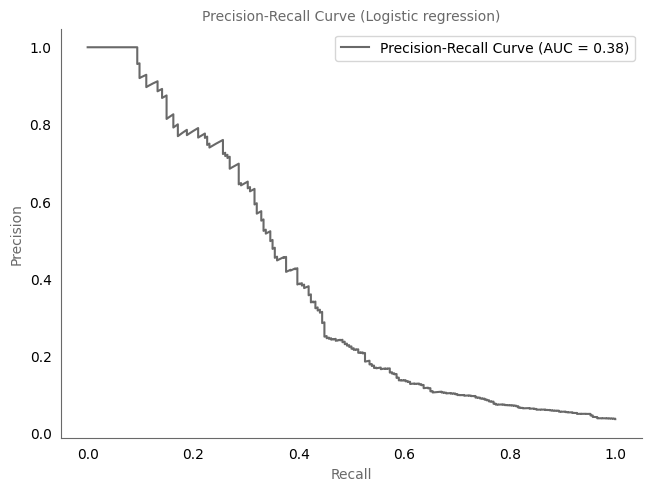

In [65]:
# Create a pipeline with a classifier and a quantile transformer
num_cols = ['Process temperature [K]','Rotational speed [rpm]','Torque [Nm]','Tool wear [min]']
preprocessor = ColumnTransformer(transformers=[('scaler', MinMaxScaler(), num_cols)], remainder='passthrough')
pipe = Pipeline([('preprocessor', preprocessor), ('lr', LogisticRegression(solver='liblinear', **best_params))])

# Use StratifiedKFold for cross-validation to maintain class balance
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validated predictions
y_pred = cross_val_predict(pipe, X_train, y_train, cv=cv, method='predict_proba')[:, 1]

# Calculate precision and recall
precisions, recalls, thresholds = precision_recall_curve(y_train, y_pred)

# Calculate area under the curve (AUC)
auc_score = auc(recalls, precisions)

# Plot figure
fig, axes = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(6.4, 4.8))
axes.tick_params(bottom=False, left=False)
axes.grid(False)
axes.spines[['top', 'right']].set_visible(False)
axes.spines[['left', 'bottom']].set_color('dimgray')

axes.plot(recalls, precisions, label=f'Precision-Recall Curve (AUC = {auc_score:.2f})', color='dimgray', alpha=1)
axes.set_title('Precision-Recall Curve (Logistic regression)',fontsize=10, color='dimgray')
axes.set_xlabel('Recall',fontsize=10, color='dimgray')
axes.set_ylabel('Precision',fontsize=10, color='dimgray')
axes.legend();

In [66]:
# Compute best recall given a minimum precision
min_precision = 0.5
optimal_threshold, optimal_precision, optimal_recall = find_optimal_threshold(precisions, recalls, thresholds, min_precision)
print(f"Optimal threshold: {optimal_threshold}")
print(f"Optimal recall: {optimal_recall}")
print(f"Optimal precision: {optimal_precision}")

Optimal threshold: 0.5011326100874743
Optimal recall: 0.3504273504273504
Optimal precision: 0.5


**Conclusion**

* The goal is to maximise recall whilst ensuring precision is at least $0.5$. The maximum recall, given this constraint, was $0.35$.

* Logistic regression therefore does not perform sufficiently well. This may be due to the assumption of a linear decision boundary (for log-odds).

### SVM

**Hyperparameter selection**

* The regularisation term (L1/L2) cannot be optimised using the scikit-learn implementation. It is set to L2 regularisation automatically. 

* The following hyperparameters are optimised:
       
    1. The regularisation parameter(C)
       
       Note: It represents the inverse of regularization strength.
       
    2. The class weight.
       
        Note: A common heuristic is to set the class weights inversely proportional to the class frequencies:

        $\text{class weight} = \{0: 1, 1: \text{majority class instances / minority class instances}\}$

    3. The kernel type (RBF/polynomial)
 
    4. The influence of each training example (gamma).
 
       Note: Higher values lead to a tighter decision boundary.
 
    6. The degree of the polynomial kernel function.
 
       Note: Higher values can lead to overfitting. This is ignored when using the RBF kernel.

In [67]:
# Create a pipeline with a classifier (SVM) and a scaler
num_cols = ['Process temperature [K]','Rotational speed [rpm]','Torque [Nm]','Tool wear [min]']
preprocessor = ColumnTransformer(transformers=[('scaler', MinMaxScaler(), num_cols)], remainder='passthrough')
pipe = Pipeline([('preprocessor', preprocessor), ('svm', SVC())])

# Define hyperparameters to tune
param_grid = {'svm__kernel': ['poly', 'rbf'],
              'svm__degree': [3],
              'svm__gamma': ['scale', 'auto'],
              'svm__C': [0.1, 1, 10],
              'svm__class_weight': [None, 'balanced', {0: 1, 1: 10}, {0: 1, 1: 20}]}

# Use StratifiedKFold for cross-validation to maintain class balance
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipe, param_grid, cv=cv, scoring='f1')
grid_search.fit(X_train, y_train)

# Get the best estimator from grid search
best_pipeline = grid_search.best_estimator_
print("Best kernel:", grid_search.best_params_['svm__kernel'])
print("Best degree:", grid_search.best_params_['svm__degree'])
print("Best gamma:", grid_search.best_params_['svm__gamma'])
print("Best Regularization Parameter (C):", grid_search.best_params_['svm__C'])
print("Best class weight:", grid_search.best_params_['svm__class_weight'])

Best kernel: rbf
Best degree: 3
Best gamma: auto
Best Regularization Parameter (C): 1
Best class weight: {0: 1, 1: 10}


**Performance**

* K-fold cross validation is used to assess the performance of the optimal configuration.

* SVM's are not naturally probabilistic. Therefore no classification threshold is assumed.

* A stratified split is used to maintain the class balance.

**_Key observations_**

* Recall is $0.58$. This means the ability of the model to identify all failed machinery is higher than with Naive Bayes ($0.2$) or Logistic regression ($0.35$).

    $Recall = \frac{TP}{TP+FN}$

* Precision is $0.36$. This means roughly $36\%$ of of failed predictions are correct. This is lower than for Naive Bayes ($0.5$) or Logistic regression ($0.48$).

    $Precision = \frac{TP}{TP+FP}$

In [68]:
best_params = {key.lstrip('svm__'):value for key,value in grid_search.best_params_.items()}

# Use StratifiedKFold for cross-validation to maintain class balance
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Iterate over k-folds
precision, recall, f1 = [], [], []
for train_index, test_index in cv.split(X_train, y_train):
    X_train_k, y_train_k = X_train_scaled.loc[train_index], y_train_scaled.loc[train_index]
    X_test_k, y_test_k = X_train_scaled.loc[test_index], y_train_scaled.loc[test_index]

    # Create a pipeline with a classifier and a scaler
    num_cols = ['Process temperature [K]','Rotational speed [rpm]','Torque [Nm]','Tool wear [min]']
    preprocessor = ColumnTransformer(transformers=[('scaler', MinMaxScaler(), num_cols)], remainder='passthrough')
    pipe = Pipeline([('preprocessor', preprocessor), ('svm', SVC(**best_params))])

    # Perform predictions
    pipe.fit(X_train_k, y_train_k)
    y_pred_k = pipe.predict(X_test_k)
    
    # Calculate precision, recall & f1-score
    precision.append(precision_score(y_test_k, y_pred_k))
    recall.append(recall_score(y_test_k, y_pred_k))
    f1.append(f1_score(y_test_k, y_pred_k))

print(f"Precision: {np.mean(precision)}")
print(f"Recall: {np.mean(recall)}")
print(f"F1: {np.sqrt(np.mean(f1))}")

Precision: 0.3639475045304704
Recall: 0.581036077705828
F1: 0.6687025750987511


**Performance as function of classification threshold**

* A probabilistic variant of SVM can be used to output a probability rather than a class.

* Performance can then be assesed as a function of classification threshold using a precision-recall curve.

* This illustrates the trade-off between precision and recall at different classification thresholds:

    - As the classification threshold is lowered (moving to the right on the plot), the recall increases (as the number of FNs decreases) but the precision decreases (as the number of FPs increases)

    - As the classification threshold is increased (moving to the left on the plot), the precision increases (as the number of FPs decreases) but the recall decreases (as the number of FNs increases)

* Similar to above, K-fold cross validation is coupled with a stratified split (to maintain the class balance).

**_Key observations_**

* The AUC is $0.51$. This is higher than for Naive Bayes ($0.37$) and Logistic regression ($0.38$).

* The goal is to optimise recall whilst meeting a nominal constraint of $50\%$ precision.

* The precision-recall curve shows the maximum recall possible given this constraint is $0.51$.

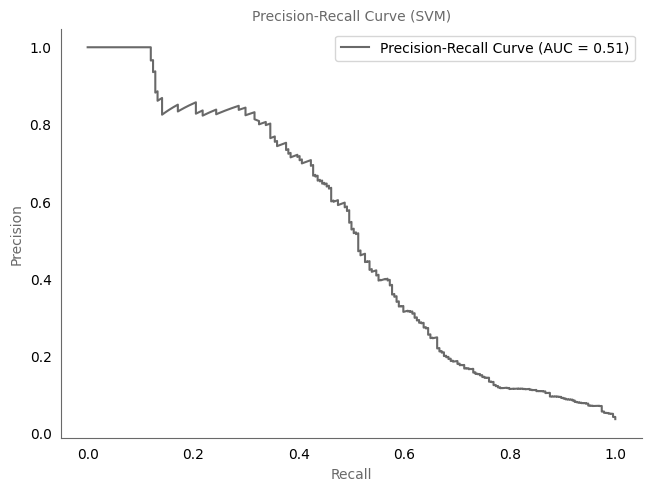

In [69]:
# Create a pipeline with a classifier and a quantile transformer
num_cols = ['Process temperature [K]','Rotational speed [rpm]','Torque [Nm]','Tool wear [min]']
preprocessor = ColumnTransformer(transformers=[('scaler', MinMaxScaler(), num_cols)], remainder='passthrough')
pipe = Pipeline([('preprocessor', preprocessor), ('svm', SVC(probability=True, **best_params))])

# Use StratifiedKFold for cross-validation to maintain class balance
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validated predictions
y_pred = cross_val_predict(pipe, X_train, y_train, cv=cv, method='predict_proba')[:, 1]

# Calculate precision and recall
precisions, recalls, thresholds = precision_recall_curve(y_train, y_pred)

# Calculate area under the curve (AUC)
auc_score = auc(recalls, precisions)

# Plot figure
fig, axes = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(6.4, 4.8))
axes.tick_params(bottom=False, left=False)
axes.grid(False)
axes.spines[['top', 'right']].set_visible(False)
axes.spines[['left', 'bottom']].set_color('dimgray')

axes.plot(recalls, precisions, label=f'Precision-Recall Curve (AUC = {auc_score:.2f})', color='dimgray', alpha=1)
axes.set_title('Precision-Recall Curve (SVM)',fontsize=10, color='dimgray')
axes.set_xlabel('Recall',fontsize=10, color='dimgray')
axes.set_ylabel('Precision',fontsize=10, color='dimgray')
axes.legend();

In [70]:
# Compute best recall given a minimum precision
min_precision = 0.5
optimal_threshold, optimal_precision, optimal_recall = find_optimal_threshold(precisions, recalls, thresholds, min_precision)
print(f"Optimal threshold: {optimal_threshold}")
print(f"Optimal recall: {optimal_recall}")
print(f"Optimal precision: {optimal_precision}")

Optimal threshold: 0.2289177256465795
Optimal recall: 0.5128205128205128
Optimal precision: 0.5


**Conclusion**

* The goal is to maximise recall whilst ensuring precision is at least $0.5$. The maximum recall, given this constraint, was $0.51$.

* SVM with an RBF kernel therefore performs better than both Naive Bayes and Logistic regression. This suggests a non-linear decision boundary is present.

### Random forest

**Hyperparameter selection**

* The following hyperparameters are optimised:
       
    1. The number of estimators.
       
    2. The maximum depth of the trees.
       
        Note: If None, then nodes are expanded until all leaves are pure or until all leaves contain less than *min_samples_split* samples.

    3. The minimum number of samples required to split an internal node is optimised.

In [73]:
# Create a pipeline with a classifier (random forest) and a scaler
num_cols = ['Process temperature [K]','Rotational speed [rpm]','Torque [Nm]','Tool wear [min]']
preprocessor = ColumnTransformer(transformers=[('scaler', MinMaxScaler(), num_cols)], remainder='passthrough')
pipe = Pipeline([('preprocessor', preprocessor), ('rf', RandomForestClassifier())])

# Define hyperparameters to tune
param_grid = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [None, 10, 20],
    'rf__min_samples_split': [2, 5, 10],
}

# Use StratifiedKFold for cross-validation to maintain class balance
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipe, param_grid, cv=cv, scoring='f1')
grid_search.fit(X_train, y_train)

# Get the best estimator from grid search
best_pipeline = grid_search.best_estimator_
print("Best n_estimators:", grid_search.best_params_['rf__n_estimators'])
print("Best max_depth:", grid_search.best_params_['rf__max_depth'])
print("Best min_samples_split:", grid_search.best_params_['rf__min_samples_split'])

Best n_estimators: 300
Best max_depth: 20
Best min_samples_split: 5


**Performance**

* K-fold cross validation is used to assess the performance of the optimal configuration with a classification threshold of $0.5$

* A stratified split is used to maintain the class balance.

**_Key observations_**

* Recall is $0.4$. This means the ability of the model to identify all failed machinery is higher than with Naive Bayes ($0.2$) and Logistic regression ($0.35$) but lower than SVM ($0.58$).

    $Recall = \frac{TP}{TP+FN}$

* Precision is $0.82$. This means roughly $82\%$ of of failed predictions are correct. This is higher than for Naive Bayes ($0.5$), Logistic regression ($0.48$) and SVM ($0.36$).

    $Precision = \frac{TP}{TP+FP}$

In [74]:
best_params = {key.lstrip('rf__'):value for key,value in grid_search.best_params_.items()}

# Use StratifiedKFold for cross-validation to maintain class balance
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Iterate over k-folds
precision, recall, f1 = [], [], []
for train_index, test_index in cv.split(X_train, y_train):
    X_train_k, y_train_k = X_train_scaled.loc[train_index], y_train_scaled.loc[train_index]
    X_test_k, y_test_k = X_train_scaled.loc[test_index], y_train_scaled.loc[test_index]

    # Create a pipeline with a classifier and a scaler
    num_cols = ['Process temperature [K]','Rotational speed [rpm]','Torque [Nm]','Tool wear [min]']
    preprocessor = ColumnTransformer(transformers=[('scaler', MinMaxScaler(), num_cols)], remainder='passthrough')
    pipe = Pipeline([('preprocessor', preprocessor), ('rf', RandomForestClassifier(**best_params))])

    # Perform predictions
    pipe.fit(X_train_k, y_train_k)
    y_pred_k = pipe.predict(X_test_k)
    
    # Calculate precision, recall & f1-score
    precision.append(precision_score(y_test_k, y_pred_k))
    recall.append(recall_score(y_test_k, y_pred_k))
    f1.append(f1_score(y_test_k, y_pred_k))

print(f"Precision: {np.mean(precision)}")
print(f"Recall: {np.mean(recall)}")
print(f"F1: {np.sqrt(np.mean(f1))}")

Precision: 0.8217375957375956
Recall: 0.4014801110083256
F1: 0.7336943309199588


**Performance as function of classification threshold**

* Performance is assesed as a function of classification threshold using a precision-recall curve.

* This illustrates the trade-off between precision and recall at different classification thresholds:

    - As the classification threshold is lowered (moving to the right on the plot), the recall increases (as the number of FNs decreases) but the precision decreases (as the number of FPs increases)

    - As the classification threshold is increased (moving to the left on the plot), the precision increases (as the number of FPs decreases) but the recall decreases (as the number of FNs increases)

* Similar to above, K-fold cross validation is coupled with a stratified split (to maintain the class balance).

**_Key observations_**

* The AUC is $0.62$. This is higher than for Naive Bayes ($0.37$), Logistic regression ($0.38$) and SVM ($0.51$).

* The goal is to optimise recall whilst meeting a nominal constraint of $50\%$ precision.

* The precision-recall curve shows the maximum recall possible given this constraint is $0.57$.

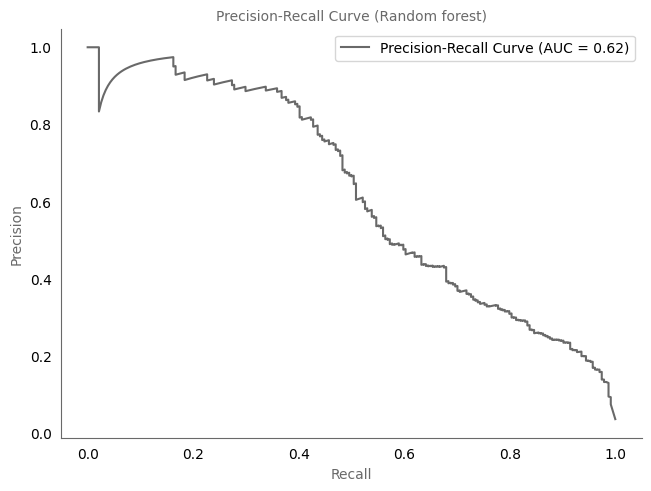

In [76]:
# Create a pipeline with a classifier and a quantile transformer
num_cols = ['Process temperature [K]','Rotational speed [rpm]','Torque [Nm]','Tool wear [min]']
preprocessor = ColumnTransformer(transformers=[('scaler', MinMaxScaler(), num_cols)], remainder='passthrough')
pipe = Pipeline([('preprocessor', preprocessor), ('rf', RandomForestClassifier(**best_params))])

# Use StratifiedKFold for cross-validation to maintain class balance
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validated predictions
y_pred = cross_val_predict(pipe, X_train, y_train, cv=cv, method='predict_proba')[:, 1]

# Calculate precision and recall
precisions, recalls, thresholds = precision_recall_curve(y_train, y_pred)

# Calculate area under the curve (AUC)
auc_score = auc(recalls, precisions)

# Plot figure
fig, axes = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(6.4, 4.8))
axes.tick_params(bottom=False, left=False)
axes.grid(False)
axes.spines[['top', 'right']].set_visible(False)
axes.spines[['left', 'bottom']].set_color('dimgray')

axes.plot(recalls, precisions, label=f'Precision-Recall Curve (AUC = {auc_score:.2f})', color='dimgray', alpha=1)
axes.set_title('Precision-Recall Curve (Random forest)',fontsize=10, color='dimgray')
axes.set_xlabel('Recall',fontsize=10, color='dimgray')
axes.set_ylabel('Precision',fontsize=10, color='dimgray')
axes.legend();

In [77]:
# Compute best recall given a minimum precision
min_precision = 0.5
optimal_threshold, optimal_precision, optimal_recall = find_optimal_threshold(precisions, recalls, thresholds, min_precision)
print(f"Optimal threshold: {optimal_threshold}")
print(f"Optimal recall: {optimal_recall}")
print(f"Optimal precision: {optimal_precision}")

Optimal threshold: 0.261526455026455
Optimal recall: 0.5726495726495726
Optimal precision: 0.5


**Conclusion**

* The goal is to maximise recall whilst ensuring precision is at least $0.5$. The maximum recall, given this constraint, was $0.57$.

* The Random Forest model is the best so far. This may be due to the reduction in overfitting and therefore variance granted via bagging (bootstrap aggregating). 

### XGBoost

**Hyperparameter selection**

* The following hyperparameters are optimised:
       
    1. The number of estimators.
       
    2. The maximum depth of the trees.

    3. The learning rate.

In [79]:
# Create a pipeline with a classifier (XGBoost) and a scaler
num_cols = ['Process temperature [K]','Rotational speed [rpm]','Torque [Nm]','Tool wear [min]']
preprocessor = ColumnTransformer(transformers=[('scaler', MinMaxScaler(), num_cols)], remainder='passthrough')
pipe = Pipeline([('preprocessor', preprocessor), ('xgb', XGBClassifier())])

# Define hyperparameters to tune
param_grid = {
    'xgb__n_estimators': [50, 100, 200],
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
}

# Use StratifiedKFold for cross-validation to maintain class balance
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipe, param_grid, cv=cv, scoring='f1')
grid_search.fit(X_train, y_train)

# Get the best estimator from grid search
best_pipeline = grid_search.best_estimator_
print("Best n_estimators:", grid_search.best_params_['xgb__n_estimators'])
print("Best max_depth:", grid_search.best_params_['xgb__max_depth'])
print("Best learning_rate:", grid_search.best_params_['xgb__learning_rate'])

Best n_estimators: 100
Best max_depth: 5
Best learning_rate: 0.1


**Performance**

* K-fold cross validation is used to assess the performance of the optimal configuration with a classification threshold of $0.5$

* A stratified split is used to maintain the class balance.

**_Key observations_**

* Recall is $0.39$. This means the ability of the model to identify all failed machinery is higher than with Naive Bayes ($0.2$), Logistic regression ($0.35$) and SVM ($0.58$). It is roughly the same as for a random forest ($0.4$).

    $Recall = \frac{TP}{TP+FN}$

* Precision is $0.75$. This means roughly $75\%$ of of failed predictions are correct. This is higher than for Naive Bayes ($0.5$), Logistic regression ($0.48$) and SVM ($0.36$) but lower than for a Random Forest ($0.82$).

    $Precision = \frac{TP}{TP+FP}$

In [80]:
best_params = {key.lstrip('xgb__'):value for key,value in grid_search.best_params_.items()}

# Use StratifiedKFold for cross-validation to maintain class balance
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Iterate over k-folds
precision, recall, f1 = [], [], []
for train_index, test_index in cv.split(X_train, y_train):
    X_train_k, y_train_k = X_train_scaled.loc[train_index], y_train_scaled.loc[train_index]
    X_test_k, y_test_k = X_train_scaled.loc[test_index], y_train_scaled.loc[test_index]

    # Create a pipeline with a classifier and a scaler
    num_cols = ['Process temperature [K]','Rotational speed [rpm]','Torque [Nm]','Tool wear [min]']
    preprocessor = ColumnTransformer(transformers=[('scaler', MinMaxScaler(), num_cols)], remainder='passthrough')
    pipe = Pipeline([('preprocessor', preprocessor), ('xgb', XGBClassifier(**best_params))])

    # Perform predictions
    pipe.fit(X_train_k, y_train_k)
    y_pred_k = pipe.predict(X_test_k)
    
    # Calculate precision, recall & f1-score
    precision.append(precision_score(y_test_k, y_pred_k))
    recall.append(recall_score(y_test_k, y_pred_k))
    f1.append(f1_score(y_test_k, y_pred_k))

print(f"Precision: {np.mean(precision)}")
print(f"Recall: {np.mean(recall)}")
print(f"F1: {np.sqrt(np.mean(f1))}")

Precision: 0.7482240697832901
Recall: 0.3929694727104533
F1: 0.7169917865921539


**Performance as function of classification threshold**

* Performance is assesed as a function of classification threshold using a precision-recall curve.

* This illustrates the trade-off between precision and recall at different classification thresholds:

    - As the classification threshold is lowered (moving to the right on the plot), the recall increases (as the number of FNs decreases) but the precision decreases (as the number of FPs increases)

    - As the classification threshold is increased (moving to the left on the plot), the precision increases (as the number of FPs decreases) but the recall decreases (as the number of FNs increases)

* Similar to above, K-fold cross validation is coupled with a stratified split (to maintain the class balance).

**_Key observations_**

* The AUC is $0.58$. This is higher than for Naive Bayes ($0.37$), Logistic regression ($0.38$) and SVM ($0.51$) but lower than for a random forest $0.62$

* The goal is to optimise recall whilst meeting a nominal constraint of $50\%$ precision.

* The precision-recall curve shows the maximum recall possible given this constraint is $0.52$.

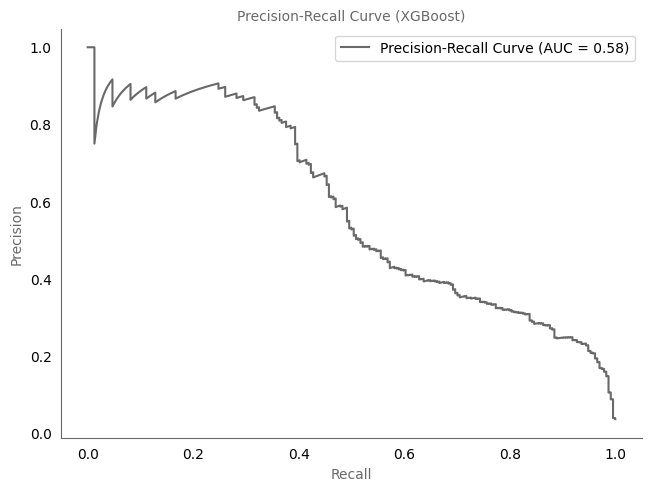

In [81]:
# Create a pipeline with a classifier and a quantile transformer
num_cols = ['Process temperature [K]','Rotational speed [rpm]','Torque [Nm]','Tool wear [min]']
preprocessor = ColumnTransformer(transformers=[('scaler', MinMaxScaler(), num_cols)], remainder='passthrough')
pipe = Pipeline([('preprocessor', preprocessor), ('xgb', XGBClassifier(**best_params))])

# Use StratifiedKFold for cross-validation to maintain class balance
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validated predictions
y_pred = cross_val_predict(pipe, X_train, y_train, cv=cv, method='predict_proba')[:, 1]

# Calculate precision and recall
precisions, recalls, thresholds = precision_recall_curve(y_train, y_pred)

# Calculate area under the curve (AUC)
auc_score = auc(recalls, precisions)

# Plot figure
fig, axes = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(6.4, 4.8))
axes.tick_params(bottom=False, left=False)
axes.grid(False)
axes.spines[['top', 'right']].set_visible(False)
axes.spines[['left', 'bottom']].set_color('dimgray')

axes.plot(recalls, precisions, label=f'Precision-Recall Curve (AUC = {auc_score:.2f})', color='dimgray', alpha=1)
axes.set_title('Precision-Recall Curve (XGBoost)',fontsize=10, color='dimgray')
axes.set_xlabel('Recall',fontsize=10, color='dimgray')
axes.set_ylabel('Precision',fontsize=10, color='dimgray')
axes.legend();

In [82]:
# Compute best recall given a minimum precision
min_precision = 0.5
optimal_threshold, optimal_precision, optimal_recall = find_optimal_threshold(precisions, recalls, thresholds, min_precision)
print(f"Optimal threshold: {optimal_threshold}")
print(f"Optimal recall: {optimal_recall}")
print(f"Optimal precision: {optimal_precision}")

Optimal threshold: 0.2601698040962219
Optimal recall: 0.5170940170940171
Optimal precision: 0.5


**Conclusion**

* The goal is to maximise recall whilst ensuring precision is at least $0.5$. The maximum recall, given this constraint, was $0.52$.

* XGBoost therefore did not perform as well as a random forest.

### Random forest with SMOTE

**Hyperparameter selection**

* The following hyperparameters are optimised:
       
    1. The number of estimators.
       
    2. The maximum depth of the trees.
       
        Note: If None, then nodes are expanded until all leaves are pure or until all leaves contain less than *min_samples_split* samples.

    3. The minimum number of samples required to split an internal node is optimised.
 
    4. The SMOTE sampling strategy.

In [83]:
# Create a pipeline with a classifier, a scaler, and SMOTE
num_cols = ['Process temperature [K]','Rotational speed [rpm]','Torque [Nm]','Tool wear [min]']
preprocessor = ColumnTransformer(transformers=[('scaler', MinMaxScaler(), num_cols)], remainder='passthrough')

# Combine all steps in a single pipeline
pipe = make_pipeline(preprocessor, SMOTE(random_state=42), RandomForestClassifier())

# Define hyperparameters to tune
param_grid = {
    'smote__sampling_strategy': [0.1, 0.5, 1.0],
    'randomforestclassifier__n_estimators': [50, 100, 200],
    'randomforestclassifier__max_depth': [None, 10, 20],
    'randomforestclassifier__min_samples_split': [10, 20, 30],
}

# Use StratifiedKFold for cross-validation to maintain class balance
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipe, param_grid, cv=cv, scoring='f1')
grid_search.fit(X_train, y_train)

# Get the best estimator from grid search
best_pipeline = grid_search.best_estimator_

# Print the best parameters
print("Best Sampling Strategy:", grid_search.best_params_['smote__sampling_strategy'])
print("Best n_estimators:", grid_search.best_params_['randomforestclassifier__n_estimators'])
print("Best max_depth:", grid_search.best_params_['randomforestclassifier__max_depth'])
print("Best min_samples_split:", grid_search.best_params_['randomforestclassifier__min_samples_split'])

Best Sampling Strategy: 0.1
Best n_estimators: 100
Best max_depth: 10
Best min_samples_split: 20


**Performance**

* K-fold cross validation is used to assess the performance of the optimal configuration with a classification threshold of $0.5$

* A stratified split is used to maintain the class balance.

**_Key observations_**

* Recall is $TBC$. This means the ability of the model to identify all failed machinery is higher than with Naive Bayes ($0.2$), Logistic regression ($0.35$) and SVM ($0.58$). It is roughly the same as for a random forest ($0.4$).

    $Recall = \frac{TP}{TP+FN}$

* Precision is $TBC$. This means roughly $75\%$ of of failed predictions are correct. This is higher than for Naive Bayes ($0.5$), Logistic regression ($0.48$) and SVM ($0.36$) but lower than for a Random Forest ($0.82$).

    $Precision = \frac{TP}{TP+FP}$

In [84]:
rf_best_params = {key:value for key, value in grid_search.best_params_.items() if 'randomforestclassifier__' in key}
rf_best_params = {key.replace('randomforestclassifier__',''):value for key, value in rf_best_params.items()}

smote_best_params = {key:value for key, value in grid_search.best_params_.items() if 'smote__' in key}
smote_best_params = {key.replace('smote__',''):value for key, value in smote_best_params.items()}

# Use StratifiedKFold for cross-validation to maintain class balance
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Iterate over k-folds
precision, recall, f1 = [], [], []
for train_index, test_index in cv.split(X_train, y_train):
    X_train_k, y_train_k = X_train_scaled.loc[train_index], y_train_scaled.loc[train_index]
    X_test_k, y_test_k = X_train_scaled.loc[test_index], y_train_scaled.loc[test_index]

    # Create a pipeline with a classifier and a scaler
    num_cols = ['Process temperature [K]','Rotational speed [rpm]','Torque [Nm]','Tool wear [min]']
    preprocessor = ColumnTransformer(transformers=[('scaler', MinMaxScaler(), num_cols)], remainder='passthrough')
    pipe = make_pipeline(preprocessor, SMOTE(random_state=42, **smote_best_params), RandomForestClassifier(**rf_best_params))

    # Perform predictions
    pipe.fit(X_train_k, y_train_k)
    y_pred_k = pipe.predict(X_test_k)
    
    # Calculate precision, recall & f1-score
    precision.append(precision_score(y_test_k, y_pred_k))
    recall.append(recall_score(y_test_k, y_pred_k))
    f1.append(f1_score(y_test_k, y_pred_k))

print(f"Precision: {np.mean(precision)}")
print(f"Recall: {np.mean(recall)}")
print(f"F1: {np.sqrt(np.mean(f1))}")

Precision: 0.627887533651776
Recall: 0.4611470860314523
F1: 0.7278079932863283


**Performance as function of classification threshold**

* Performance is assesed as a function of classification threshold using a precision-recall curve.

* This illustrates the trade-off between precision and recall at different classification thresholds:

    - As the classification threshold is lowered (moving to the right on the plot), the recall increases (as the number of FNs decreases) but the precision decreases (as the number of FPs increases)

    - As the classification threshold is increased (moving to the left on the plot), the precision increases (as the number of FPs decreases) but the recall decreases (as the number of FNs increases)

* Similar to above, K-fold cross validation is coupled with a stratified split (to maintain the class balance).

**_Key observations_**

* The AUC is $0.58$. This is higher than for Naive Bayes ($0.37$), Logistic regression ($0.38$) and SVM ($0.51$) but lower than for a random forest $0.62$

* The goal is to optimise recall whilst meeting a nominal constraint of $50\%$ precision.

* The precision-recall curve shows the maximum recall possible given this constraint is $0.52$.

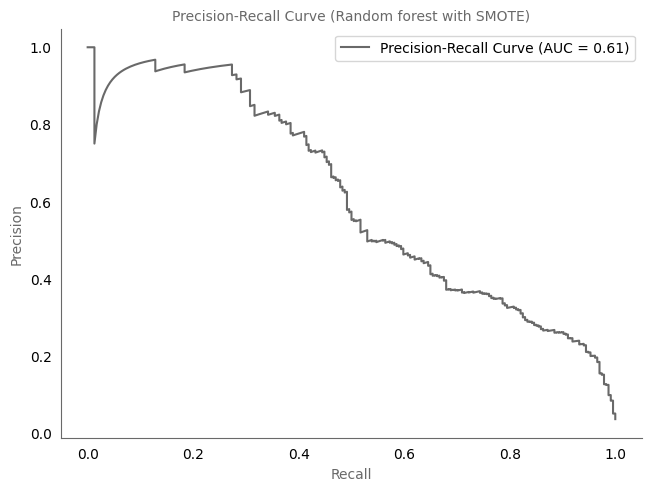

In [85]:
# Create a pipeline with a classifier and a quantile transformer
num_cols = ['Process temperature [K]','Rotational speed [rpm]','Torque [Nm]','Tool wear [min]']
preprocessor = ColumnTransformer(transformers=[('scaler', MinMaxScaler(), num_cols)], remainder='passthrough')
pipe = make_pipeline(preprocessor, SMOTE(random_state=42, **smote_best_params), RandomForestClassifier(**rf_best_params))

# Use StratifiedKFold for cross-validation to maintain class balance
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validated predictions
y_pred = cross_val_predict(pipe, X_train, y_train, cv=cv, method='predict_proba')[:, 1]

# Calculate precision and recall
precisions, recalls, thresholds = precision_recall_curve(y_train, y_pred)

# Calculate area under the curve (AUC)
auc_score = auc(recalls, precisions)

# Plot figure
fig, axes = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(6.4, 4.8))
axes.tick_params(bottom=False, left=False)
axes.grid(False)
axes.spines[['top', 'right']].set_visible(False)
axes.spines[['left', 'bottom']].set_color('dimgray')

axes.plot(recalls, precisions, label=f'Precision-Recall Curve (AUC = {auc_score:.2f})', color='dimgray', alpha=1)
axes.set_title('Precision-Recall Curve (Random forest with SMOTE)',fontsize=10, color='dimgray')
axes.set_xlabel('Recall',fontsize=10, color='dimgray')
axes.set_ylabel('Precision',fontsize=10, color='dimgray')
axes.legend();

In [86]:
# Compute best recall given a minimum precision
min_precision = 0.5
optimal_threshold, optimal_precision, optimal_recall = find_optimal_threshold(precisions, recalls, thresholds, min_precision)
print(f"Optimal threshold: {optimal_threshold}")
print(f"Optimal recall: {optimal_recall}")
print(f"Optimal precision: {optimal_precision}")

Optimal threshold: 0.41857833739240674
Optimal recall: 0.5641025641025641
Optimal precision: 0.5


**Conclusion**

* The goal is to maximise recall whilst ensuring precision is at least $0.5$. The maximum recall, given this constraint, was $0.52$.

* XGBoost therefore did not perform as well as a random forest.

## Model evaluation

| Model | Threshold | Recall | Precision | AUC |
|----------|----------|----------|----------|----------|
| Naive Bayes   | 0.5   |0.21   | 0.5   | 0.37|
| Logistic regression   | 0.5   | 0.35   | 0.5   | 0.37   |
| SVM   | 0.23   | 0.51   | 0.5   | 0.51 |
| Random Forest   | 0.26   | 0.57   | 0.5   | 0.62   |
| XGBoost   | 0.26   | 0.52   | 0.5   | 0.58|
| Random Forest with SMOTE   | 0.42 |0.56  | 0.5   | 0.61    |

In [87]:
# Retrain with entire training set
num_cols = ['Process temperature [K]','Rotational speed [rpm]','Torque [Nm]','Tool wear [min]']
preprocessor = ColumnTransformer(transformers=[('scaler', MinMaxScaler(), num_cols)], remainder='passthrough')
pipe = make_pipeline(preprocessor, RandomForestClassifier(**rf_best_params))
# pipe = make_pipeline(preprocessor, SMOTE(random_state=42, **smote_best_params), RandomForestClassifier(**rf_best_params))
pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', MinMaxScaler(),
                                                  ['Process temperature [K]',
                                                   'Rotational speed [rpm]',
                                                   'Torque [Nm]',
                                                   'Tool wear [min]'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=10, min_samples_split=20))])

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3195
           1       0.55      0.56      0.55       105

    accuracy                           0.97      3300
   macro avg       0.77      0.77      0.77      3300
weighted avg       0.97      0.97      0.97      3300



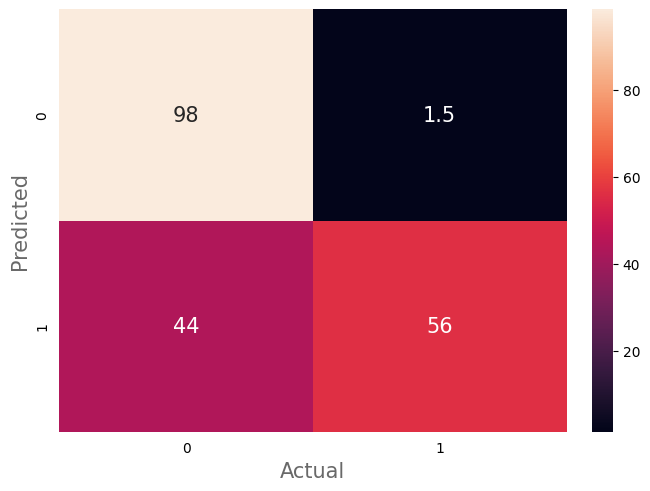

In [99]:
# Evaluate with test set

# Predict
prob_pred = pipe.predict_proba(X_test)[:, 1]

# Set a custom threshold for classification
custom_threshold = 0.26
y_pred = (prob_pred >= custom_threshold).astype(int)

# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
# Source: https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
confusion_matrices_count = confusion_matrix(y_test, y_pred)
confusion_matrices_perc = confusion_matrix(y_test, y_pred, normalize='true')*100

# Plot confusion matrix
confusion_matrices_perc  = confusion_matrices_perc .round(1)
labels = [f"{c}\n{p}%" for c, p in zip(confusion_matrices_count.flatten(), confusion_matrices_perc.flatten())]
labels = np.asarray(labels).reshape(2,2)

fig, axes = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(6.4, 4.8))
axes.tick_params(bottom=False, left=False)
axes.grid(False)
axes.spines[['top', 'right']].set_visible(False)
axes.spines[['left', 'bottom']].set_color('dimgray')

sns.heatmap(confusion_matrices_perc, ax=axes, annot=True, annot_kws={"fontsize":15})
axes.set_xlabel('Actual',fontsize=15, color='dimgray')
axes.set_ylabel('Predicted',fontsize=15, color='dimgray');

## Conclusion